In [ ]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# install huggingface libraries
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Importing BERT Libraries

In [ ]:
# BERT imports
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
!ls /drive/My\ Drive/Data

cache_train  checkpoint-1000  test.csv	train.csv  train-v2.0.json  val.csv


In [ ]:
import sys
sys.path.append('/drive/My Drive/Data')

In [ ]:
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py' !wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py'
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

--2023-01-28 16:53:30--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41529 (41K) [text/plain]
Saving to: ‘utils_squad.py’

utils_squad.py      100%[===================>]  40.56K  --.-KB/s    in 0.001s  

2023-01-28 16:53:30 (46.7 MB/s) - ‘utils_squad.py’ saved [41529/41529]

--2023-01-28 16:53:30--  http://!wget/
Resolving !wget (!wget)... failed: Name or service not known.
wget: unable to resolve host address ‘!wget’
--2023-01-28 16:53:30--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py
Reusing existing connection to raw.githubusercontent.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 124

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Loading the Input file and assigning to variable examples



In [ ]:
input_file = '/drive/My Drive/Data/train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

Printing first 5 examples

In [ ]:
examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

Converting to a pandas Dataframe

In [ ]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


creating a sample dataframe from the training data and printing the train_data that matches the context of sample data

In [ ]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
125134,573257950fdd8d15006c69eb,What action in 2007 by national governments pr...,"[It, threatened, the, collapse, of, large, fin...",bailout of banks,13,15,False,115,99
125135,573257950fdd8d15006c69ec,How much estimated consumer wealth was lost as...,"[It, threatened, the, collapse, of, large, fin...",trillions of U.S. dollars,58,61,False,115,88
125136,573257950fdd8d15006c69ed,What is the date the active phase of the finan...,"[It, threatened, the, collapse, of, large, fin...","August 9, 2007",97,99,False,115,86
125137,573257950fdd8d15006c69ee,What year did the global recession that follow...,"[It, threatened, the, collapse, of, large, fin...",2012,71,71,False,115,82
125138,573257950fdd8d15006c69ef,What was the name of the company that terminat...,"[It, threatened, the, collapse, of, large, fin...",BNP Paribas,101,102,False,115,118


creating a function to get answers based on questions in the context of the sample

In [ ]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [ ]:
print_squad_sample(train_data)

CONTEXT: 
Originally named the Institute of British Architects in London, it was formed in 1834
by several prominent architects, including Philip Hardwick, Thomas Allom, William Donthorne, Thomas Leverton Donaldson,
William Adams Nicholson, John Buonarotti Papworth, and Thomas de Grey, 2nd Earl de Grey.
QUESTION:                                                                                            ANSWER:
What was Riba's first name?                                                                          Institute of British Architects in London
In what year was the Institute of British Architects founded?                                        1834
In what city was the Institute of British Architects located?                                        London
In terms of profession, what were people like Philip Hardwick, William Adams Nicholson and Thomas de Grey?  Architects
What was Riba's banned name?                                                                         No awnser

Adding paragraph_len and question_len variables to the train_data

In [ ]:

train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
107274,572f7d4d04bcaa1900d76a13,When did the hyperinflation of 1923 occur?,"[Europe, spent, these, years, rebuilding, and,...",1923,51,51,False,140,43
93818,5ad1362b645df0001a2d1190,Setting national renewable energy targets can ...,"[Setting, national, renewable, energy, targets...",,-1,-1,True,103,77
51617,57263fe1ec44d21400f3dcc9,What breed of chicken is named after a town in...,"[A, bantam, is, a, small, variety, of, domesti...",A bantam,0,1,False,87,53
2326,56cda41362d2951400fa679b,How many people would be in the orchestra Kond...,"[Media, requests, at, the, trade, show, prompt...",50,36,36,False,112,82
101605,5a8de0b2df8bba001a0f9cfd,Which illicit drug was Feynman caught with at ...,"[According, to, Genius,, the, James, Gleick-au...",,-1,-1,True,113,54


In [ ]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.19289589392184%


The BERT Tokenizer is a tokenizer that works with BERT. It has many functionalities for any type of tokenization tasks. Downloading the tokenizer using this line of code:

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 347563.26B/s]


In [ ]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16

In [ ]:
cached_features_file = '/drive/My Drive/Data/cache_train'

Converting examples into features.
Feature Transformation is the process of converting raw data which can be of Text, Image, Graph, Time series etc.. into numerical feature (Vectors). So that we can perform all algebraic operation on it.

In [ ]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

Converting features into Tensors and build dataset

In [ ]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

Using RandomSampler to sample elements randomly and DataLoader to iterate through the dataset in batches.

In [ ]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

Creating checkpoints to the model. Checkpoints are snapshots of your working model during the training process and stores it in a non-volatile memory. In machine learning and deep learning experiments, they are essentially the things which one uses to save the current state of the model so that one can pick up from where they left.

In [ ]:
import glob
checkpoints = sorted(glob.glob('/drive/My Drive/Data/checkpoint*-[0-9]*'))

In [ ]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

Loading model from the current checkpoint and assigning the model to the default GPU using model.cuda()

In [ ]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = '/drive/My Drive/Data/checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

Loading model from checkpoint /drive/My Drive/Data/checkpoint-1000


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

using .named_parameters() to get the parameters of the model

In [ ]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[ 0.0142, -0.0340, -0.0309,  ..., -0.0203, -0.0158, -0.0406],
        [ 0.0014,  0.0060, -0.0401,  ..., -0.0007,  0.0060, -0.0096]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([-0.0001, -0.0003], device='cuda:0', requires_grad=True))


Optimizing the model with AdamW, which unlike maintaining a single learning rate through training in SGD, Adam optimizer updates the learning rate for each network weight individually.

In [ ]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

Training the model with train_data and calculating the total training loss, which is the sum of the mean masked LM [language model] likelihood and the mean next sentence prediction likelihood.

In [ ]:
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()
global_step = int(global_step)
for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1],
                'token_type_ids':  batch[2],
                'start_positions': batch[3],
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1

      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/drive/My Drive/Data/checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

***** Running training *****
  Num examples = 144262
  Num Epochs = 1
  Batch size = 16
  Total optimization steps = 9016


Iteration:  10%|▉         | 868/9016 [00:00<00:03, 2253.78it/s]/usr/local/lib/python3.8/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Iteration:  22%|██▏       | 2000/9016 [12:56<1:30:48,  1.29it/s]

Train loss: 0.6796896731257439



Iteration:  22%|██▏       | 2001/9016 [12:57<2:07:34,  1.09s/it]

Saving model checkpoint to /drive/My Drive/Data/checkpoint-2000



Iteration:  33%|███▎      | 3000/9016 [25:53<1:17:49,  1.29it/s]

Train loss: 0.8759576060374578



Iteration:  33%|███▎      | 3001/9016 [25:55<1:55:01,  1.15s/it]

Saving model checkpoint to /drive/My Drive/Data/checkpoint-3000



Iteration:  44%|████▍     | 4000/9016 [38:50<1:04:59,  1.29it/s]

Train loss: 0.9566438711211085



Iteration:  44%|████▍     | 4001/9016 [38:52<1:31:54,  1.10s/it]

Saving model checkpoint to /drive/My Drive/Data/checkpoint-4000



Iteration:  55%|█████▌    | 5000/9016 [51:47<51:51,  1.29it/s]

Train loss: 0.9932030886530876



Iteration:  55%|█████▌    | 5001/9016 [51:49<1:15:04,  1.12s/it]

Saving model checkpoint to /drive/My Drive/Data/checkpoint-5000



Iteration:  67%|██████▋   | 6000/9016 [1:04:44<39:00,  1.29it/s]

Train loss: 1.012998986457785



Iteration:  67%|██████▋   | 6001/9016 [1:04:46<56:05,  1.12s/it]

Saving model checkpoint to /drive/My Drive/Data/checkpoint-6000



Iteration:  78%|███████▊  | 7000/9016 [1:17:41<26:06,  1.29it/s]

Train loss: 1.0236349758633545



Iteration:  78%|███████▊  | 7001/9016 [1:17:44<44:48,  1.33s/it]

Saving model checkpoint to /drive/My Drive/Data/checkpoint-7000



Iteration:  89%|████████▊ | 8000/9016 [1:30:39<13:07,  1.29it/s]

Train loss: 1.0299214675053954



Iteration:  89%|████████▊ | 8001/9016 [1:30:41<20:05,  1.19s/it]

Saving model checkpoint to /drive/My Drive/Data/checkpoint-8000



Iteration: 100%|█████████▉| 9000/9016 [1:43:37<00:12,  1.29it/s]

Train loss: 1.0305115226275392



Iteration: 100%|█████████▉| 9001/9016 [1:43:39<00:17,  1.13s/it]

Saving model checkpoint to /drive/My Drive/Data/checkpoint-9000



Epoch: 100%|██████████| 1/1 [1:43:50<00:00, 6230.68s/it]


Creating a output directory which is the final check point

In [ ]:
output_dir = '/drive/My Drive/Data/checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

Creating a list of train_loss_set checkpoints

In [ ]:
train_loss_set_ckpt = torch.load('/drive/My Drive/Data/checkpoint-final/Copy of training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

Plotting the train_loss_set with Batch on x-axis and Loss on Y-axis

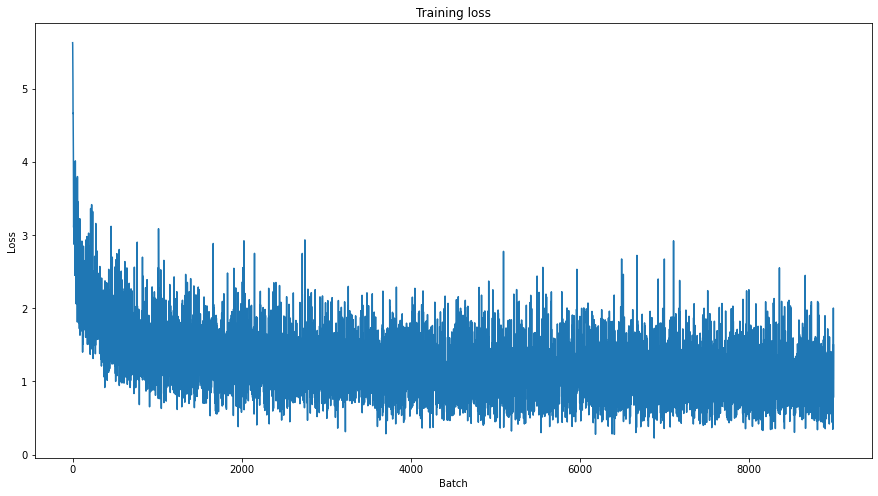

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Load test dataset**

In [ ]:
input_file = '/drive/My Drive/Data/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = '/drive/My Drive/Data/cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

Converting into Tensors and build dataset

In [ ]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

Using SequentialSampler to sample all the indexes and DataLoader to iterate through the dataset in batches.

In [ ]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

**Evaluate test dataset**

Evaluating Test dataset and creating prediction files

In [ ]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/drive/My Drive/Data//dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "/drive/My Drive/Data/predictions.json"
  output_nbest_file = "/drive/My Drive/Data/nbest_predictions.json"
  output_null_log_odds_file = "/drive/My Drive/Data/null_odds.json"
  output_dir = "/drive/My Drive/Data/predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [ ]:
results = evaluate(model, tokenizer)

***** Running evaluation *****
  Num examples = 13600
  Batch size = 16


Evaluating: 100%|██████████| 850/850 [03:34<00:00,  3.97it/s]


{
  "exact": 68.2809736376653,
  "f1": 71.56503511165683,
  "total": 11873,
  "HasAns_exact": 65.5195681511471,
  "HasAns_f1": 72.09710895423399,
  "HasAns_total": 5928,
  "NoAns_exact": 71.03448275862068,
  "NoAns_f1": 71.03448275862068,
  "NoAns_total": 5945,
  "best_exact": 68.90423650298997,
  "best_exact_thresh": -1.630974531173706,
  "best_f1": 71.86692080322528,
  "best_f1_thresh": -0.4937920570373535
}


In [ ]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 68.2809736376653}, {'f1': 71.56503511165683}, {'total': 11873}, {'HasAns_exact': 65.5195681511471}, {'HasAns_f1': 72.09710895423399}, {'HasAns_total': 5928}, {'NoAns_exact': 71.03448275862068}, {'NoAns_f1': 71.03448275862068}, {'NoAns_total': 5945}, {'best_exact': 68.90423650298997}, {'best_exact_thresh': -1.630974531173706}, {'best_f1': 71.86692080322528}, {'best_f1_thresh': -0.4937920570373535}]
